In [1]:
# Import Libraries
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import numpy as np
import seaborn as sns
import talib as ta
import bs4 as bs
import requests
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import S&P500 Stocks price

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,7,1)
data = yf.download(tickers, start=start, end=end)

data.to_csv('SP500(2015-2021).csv')

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [4]:
#Preprocesesing Handel nulls
if data.isnull().values.any() :
    data.fillna(method='backfill',inplace=True)
    data.fillna(method='ffill',inplace=True)
    data.dropna(axis=1,inplace=True)
    print(data.isnull().sum().sum())

0


In [2]:
# Import SPY as S&P500 Index
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,7,1)
spy = yf.download('SPY', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [5]:
#Feature extarction
spy['Return'] = spy['Adj Close']/spy['Adj Close'].shift(1) - 1
spy['Next Price'] = spy['Adj Close'].shift(-1)
spy['Next Return'] = spy['Return'].shift(-1)
spy['Cumulative Return'] = (1 + spy['Return']).cumprod()
spy['Signal'] = spy['Next Return'].apply(lambda x : 1 if x>(0.005) else (-1 if x<-0.005 else 0 ))

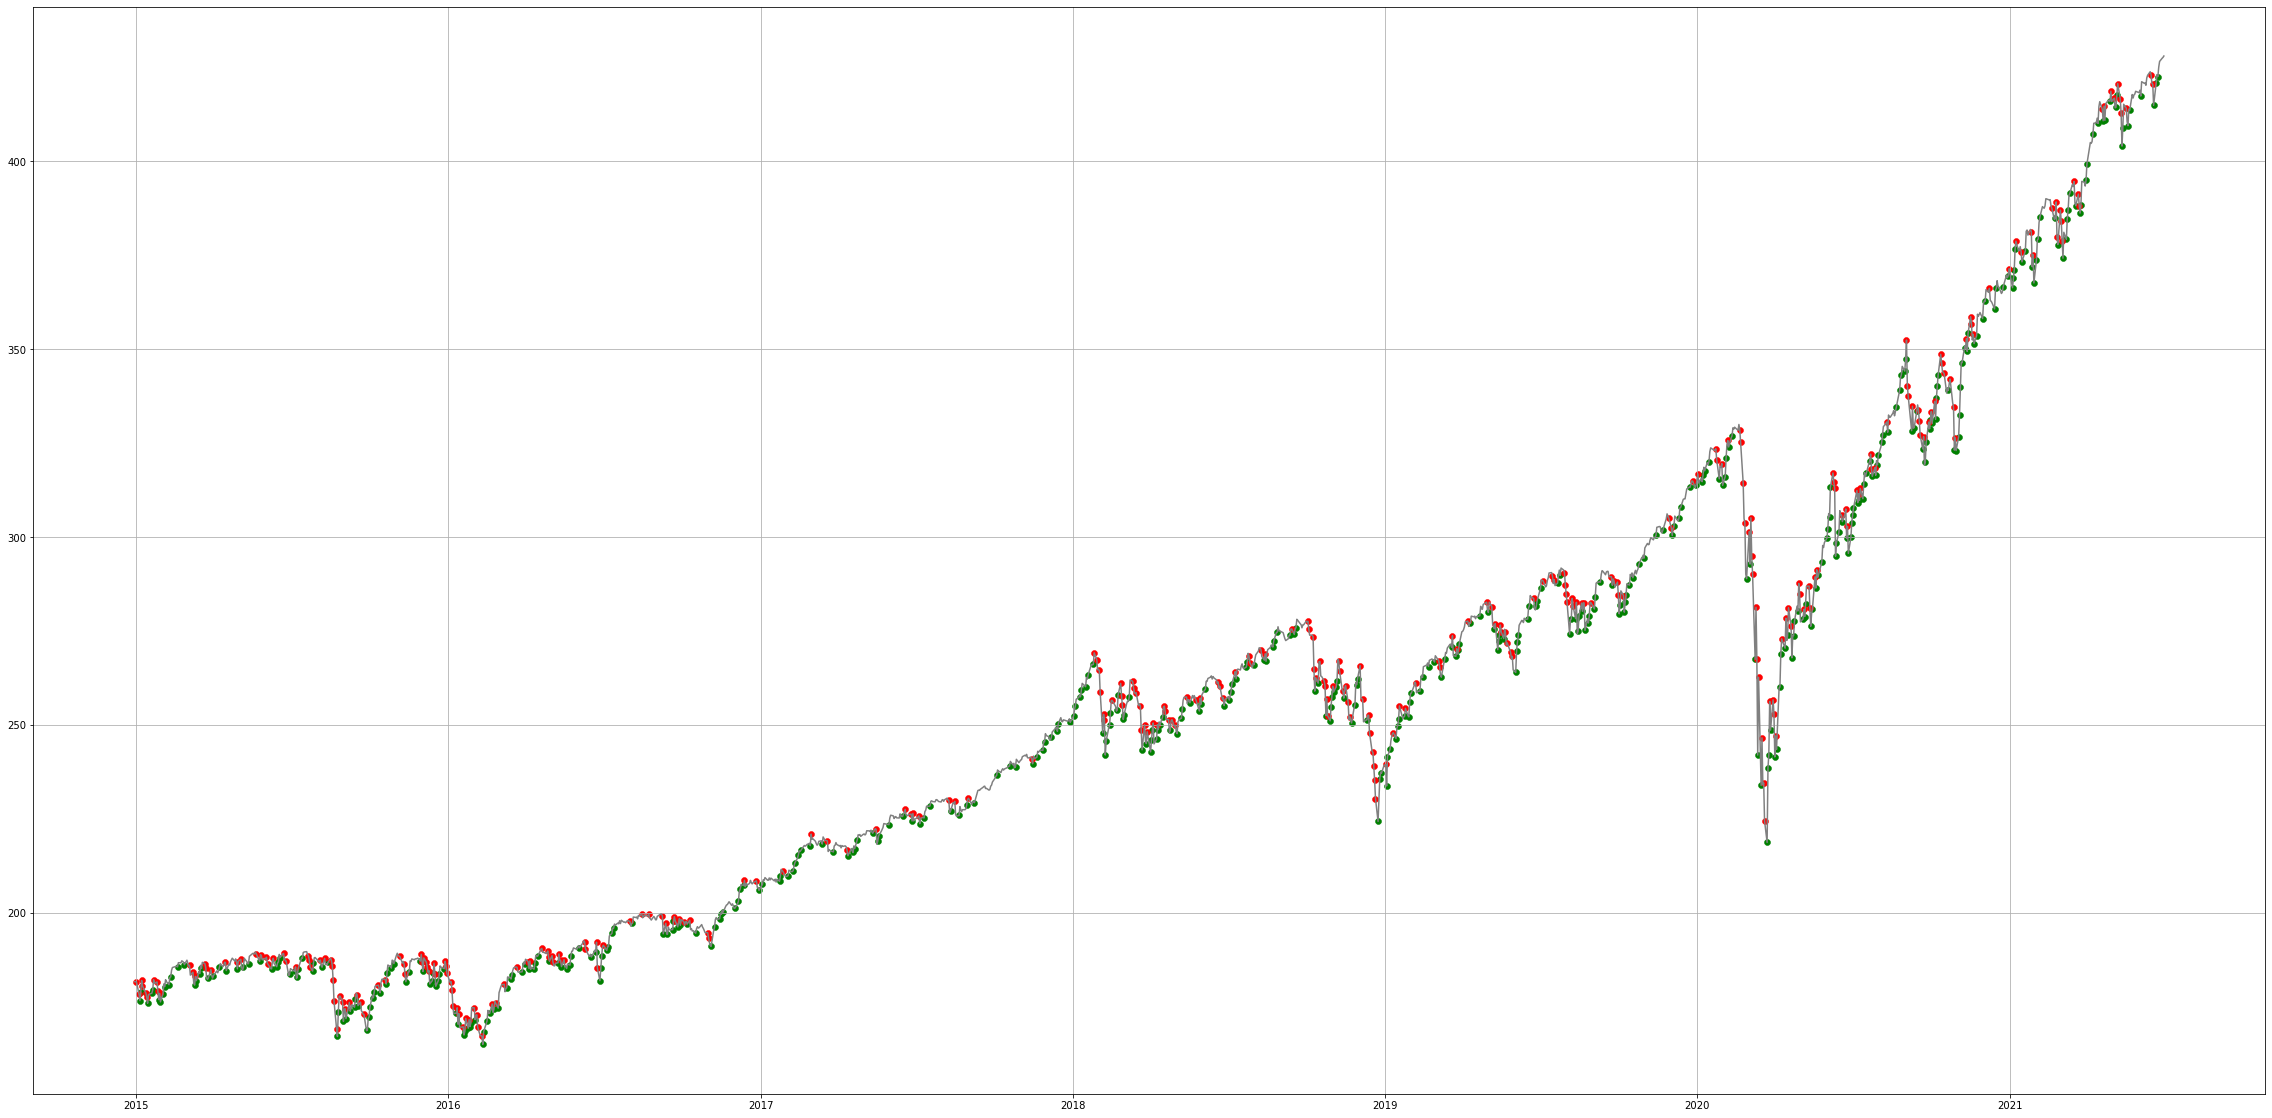

In [115]:
chart = pd.DataFrame()
chart['Price'] = spy['Adj Close']
chart['Signal'] = spy['Signal']

chart['Hold'] = chart['Price'].loc[chart['Signal']==0]
chart['Buy'] = chart['Price'].loc[chart['Signal']==1]
chart['Sell'] = chart['Price'].loc[chart['Signal']==-1]

plt.figure(figsize=(40,20))
plt.plot(chart['Price'],c='gray')
#plt.scatter(chart.index,chart['Hold'],c='gray',linewidths=0.5)
plt.scatter(chart.index,chart['Buy'],c='green',linewidths=0.5)
plt.scatter(chart.index,chart['Sell'],c='red',linewidths=0.5)
plt.grid()
plt.show()

In [159]:
#Feature Importance

y = spy['Signal'][spy.index.isin(data['Adj Close'].index)]
X = data['Adj Close'][data['Adj Close'].index.isin(spy.index)]

x_train = X.loc[X.index < '2021-01-01']
y_train = y.loc[y.index < '2021-01-01']

from sklearn.ensemble import RandomForestClassifier
fi_forest = RandomForestClassifier(random_state=42)
fi_forest.fit(x_train, y_train)
FI = pd.DataFrame()

FI['Stock'] = data['Adj Close'].columns
FI['Importance'] = fi_forest.feature_importances_

FI = FI.sort_values('Importance',ascending=False)
FI = FI.reset_index()
VIP = FI['Stock'].loc[:100].values
print (FI['Stock'].loc[:100].values)

['LEG' 'IBM' 'XOM' 'BKR' 'PVH' 'DD' 'HAL' 'MHK' 'FANG' 'GE' 'SEE' 'VNO'
 'ALK' 'KIM' 'PXD' 'PFE' 'WHR' 'BEN' 'VTR' 'DISH' 'OMC' 'L' 'JCI' 'NLSN'
 'NWL' 'MGM' 'KMI' 'APA' 'GILD' 'REG' 'VIAC' 'INCY' 'PBCT' 'WY' 'COG'
 'CAG' 'ABC' 'NLOK' 'CL' 'EOG' 'TXT' 'EIX' 'IVZ' 'NOV' 'SYF' 'REGN' 'HPQ'
 'UNM' 'EXPE' 'JNPR' 'AMGN' 'BIIB' 'OKE' 'GD' 'ALL' 'WU' 'STT' 'CERN'
 'UPS' 'EBAY' 'GNRC' 'HBI' 'CAH' 'WBA' 'RL' 'PM' 'MRO' 'EW' 'ENPH' 'CF'
 'SBAC' 'AIG' 'WAB' 'BWA' 'CTSH' 'HES' 'IP' 'UAA' 'FRT' 'LNC' 'PNR' 'TPR'
 'KHC' 'TAP' 'MDLZ' 'MOS' 'WFC' 'IPG' 'SPG' 'DG' 'EA' 'GS' 'MNST' 'LYB'
 'CMG' 'K' 'WYNN' 'SJM' 'HSIC' 'VTRS' 'CVS']


In [160]:
# Change daily price to WMA5
df_WMA5 = pd.DataFrame()
for stock in data['Adj Close'].columns :
    df_WMA5[stock] = ta.WMA(data['Adj Close'][stock],timeperiod = 5)
df_WMA5.dropna(inplace=True)

# Change daily price to RSI
df_RSI = pd.DataFrame()
for stock in data['Adj Close'].columns :
    df_RSI[stock] = ta.RSI(data['Adj Close'][stock],timeperiod = 14)
df_RSI.dropna(inplace=True)

# Make a new dataset with WMA5 , Vol , RSI
df_data = pd.DataFrame()
df_data = pd.merge(df_WMA5[VIP]
                   ,data['Volume'][VIP]
                   ,right_index=True,left_index=True,suffixes=('_wma','_vol'))
df_data = pd.merge(df_data
                   ,df_RSI[VIP]
                   ,right_index=True,left_index=True,suffixes=('','_rsi'))
df_data = pd.merge(df_data
                   ,spy[['Adj Close','Volume']]
                   ,right_index=True,left_index=True,suffixes=('','_spy'))
df_data.dropna(axis=0,inplace=True)

In [161]:
#Make a Function to measure performance

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))
        """
        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        print('\n')
        """
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))  

In [162]:
df_data

,LEG_wma,IBM_wma,XOM_wma,BKR_wma,PVH_wma,DD_wma,HAL_wma,MHK_wma,FANG_wma,GE_wma,...,LYB,CMG,K,WYNN,SJM,HSIC,VTRS,CVS,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-22,35.652783,115.819530,67.882441,34.329003,111.173757,53.705862,35.420362,167.716670,62.825307,19.812449,...,53.834508,61.410440,71.359232,47.459367,70.380651,66.129820,43.012313,70.551107,182.148209,174356000
2015-01-23,35.736111,115.979427,67.810429,34.651681,111.272272,53.747480,35.841096,167.724001,63.240486,19.980915,...,52.524476,61.492222,63.640620,45.475011,68.442171,67.486687,42.254446,71.544395,181.149490,117516800
2015-01-26,35.855463,116.196631,67.857776,34.886033,110.937084,53.684252,36.184744,167.606003,63.907676,20.130112,...,49.285105,64.636666,64.356492,59.979576,68.229261,67.953520,52.420927,72.682558,181.573700,92009700
2015-01-27,35.946855,115.782667,67.673808,35.097705,111.212771,53.483367,36.403052,166.888004,64.538323,20.166447,...,48.034047,63.433965,61.426058,58.628284,64.551201,64.683652,50.569958,71.188368,179.178635,134044600
2015-01-28,35.954383,115.004057,66.756902,34.763090,111.022367,52.823089,35.925832,166.093334,63.870505,20.024957,...,43.639778,58.243078,55.119268,55.948072,59.287177,57.187681,46.797400,62.329467,176.880768,168514300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24,50.607332,145.409333,63.772666,23.539333,106.419332,76.567334,23.480000,188.639336,92.137335,13.043407,...,37.353401,72.184770,40.181280,42.365067,33.498373,43.707739,38.754705,46.258089,425.100006,45110300
2021-06-25,51.152666,145.943999,64.288668,23.570666,108.296000,76.532668,23.717333,191.449336,93.896000,13.093374,...,36.374430,75.556506,44.473703,42.162489,37.289044,43.243211,43.862749,48.083242,426.609985,58129500
2021-06-28,51.184666,145.713997,63.970667,23.243333,108.012666,76.684002,23.414666,191.312002,93.699334,13.027360,...,35.950124,72.070989,48.381251,35.466171,43.121971,40.800464,40.566167,48.327081,427.470001,53159600


In [201]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import normalize

test_date = '2020-01-01'
y = spy['Signal'][spy.index.isin(df_data.index)]
X = df_data[df_data.index.isin(spy.index)]

result = pd.DataFrame()
result['Real'] = spy['Signal'][spy.index.isin(df_data.index)]
result['MLP'] = 0
result['RF'] = 0
result['SVM'] = 0
result['KNN'] = 0

In [202]:
#Train Part

#x_train = normalize(X.loc[X.index < test_date],axis=1)
x_train = X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]
#x_test = normalize(X.loc[X.index > test_date],axis=1)
x_test = X.loc[X.index > test_date]
y_test = y.loc[y.index > test_date]

#mlp = MLPClassifier(hidden_layer_sizes = (500,),
#                    activation = 'tanh',
#                    solver ='adam',
#                    alpha = 0.001)
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
result['MLP'].loc[result.index < test_date] = mlp.predict(x_train)

#forest = RandomForestClassifier(max_depth =  5,
#                                max_features = 'log2',
#                                min_samples_leaf = 7,
#                                min_samples_split = 7,
#                                n_estimators = 10)
forest = RandomForestClassifier()
ada_rf = AdaBoostClassifier(base_estimator=forest, n_estimators=100, learning_rate=0.5)
ada_rf.fit(x_train, y_train.ravel())
#forest.fit(x_train, y_train)
result['RF'].loc[result.index < test_date] = ada_rf.predict(x_train)

svc = SVC()
svc.fit(x_train, y_train)
result['SVM'].loc[result.index< test_date] = svc.predict(x_train)

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
result['KNN'].loc[result.index< test_date] = knn.predict(x_train)

print('MLP :')
print_score(mlp, x_train, y_train, x_test, y_test, train=True)
print_score(mlp, x_train, y_train, x_test, y_test, train=False)
print('RF with Ada :')
print_score(ada_rf, x_train, y_train,x_test, y_test, train=True)
print_score(ada_rf, x_train, y_train,x_test, y_test, train=False)
print('SVC :')
print_score(svc, x_train, y_train,x_test, y_test, train=True)
print_score(svc, x_train, y_train,x_test, y_test, train=False)
print('KNN :')
print_score(knn, x_train, y_train,x_test, y_test, train=True)
print_score(knn, x_train, y_train,x_test, y_test, train=False)

MLP :
Train Result:

accuracy score: 0.7012

Classification Report: 
               precision    recall  f1-score   support

          -1       0.68      0.38      0.49       214
           0       0.75      0.85      0.80       735
           1       0.56      0.56      0.56       296

    accuracy                           0.70      1245
   macro avg       0.66      0.60      0.62      1245
weighted avg       0.70      0.70      0.69      1245


Confusion Matrix: 
 [[ 81  85  48]
 [ 28 626  81]
 [ 11 119 166]]

Test Result:

accuracy score: 0.3926

Classification Report: 
               precision    recall  f1-score   support

          -1       0.09      0.01      0.02        93
           0       0.45      0.47      0.46       146
           1       0.37      0.57      0.45       138

    accuracy                           0.39       377
   macro avg       0.30      0.35      0.31       377
weighted avg       0.33      0.39      0.35       377


Confusion Matrix: 
 [[ 1 25 67]
 [ 9

In [203]:
# Test Part

for i in y.loc[y.index >= test_date].index :

        x_train = X.loc[X.index < i]
        y_train = y.loc[y.index < i]
        x_test = X.loc[X.index == i]
        y_test = y.loc[y.index == i]

        #mlp = MLPClassifier(hidden_layer_sizes = (500,),
        #                    activation = 'tanh',
        #                    solver ='adam',
        #                    alpha = 0.001)
        mlp = MLPClassifier()
        mlp.fit(x_train, y_train)
        result['MLP'].loc[result.index == i] = mlp.predict(x_test)[0]
        
        #forest = RandomForestClassifier(max_depth =  5,
        #                                 max_features = 'log2',
        #                                 min_samples_leaf = 7,
        #                                 min_samples_split = 7,
        #                                 n_estimators = 10)
        forest = RandomForestClassifier()
        ada_rf = AdaBoostClassifier(base_estimator=forest, n_estimators=10, learning_rate=0.5)
        ada_rf.fit(x_train, y_train.ravel())
        #forest.fit(x_train, y_train)
        result['RF'].loc[result.index == i] = ada_rf.predict(x_test)[0]
        
        svc = SVC()
        svc.fit(x_train, y_train)
        result['SVM'].loc[result.index == i] = svc.predict(x_test)[0]
        
        knn = KNeighborsClassifier()
        knn.fit(x_train, y_train)
        result['KNN'].loc[result.index == i] = knn.predict(x_test)[0]      

In [ ]:
#GridSearch for RF

from sklearn.model_selection import GridSearchCV

x_train =X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]

forest = RandomForestClassifier()

params_grid = {'n_estimators' : [10,20,50,100,200],
                'max_depth' : [5,10,15,20],
                'min_samples_split' : [2,5,7,10,20],
                'min_samples_leaf' : [1,3,5,7,10],
                'max_features' : ["auto", "sqrt", "log2"]}

grid_search = GridSearchCV(forest, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy')

grid_search.fit(x_train, y_train)

print(grid_search.best_score_)

grid_search.best_estimator_.get_params()


In [ ]:

#GridSearch for MLP

from sklearn.model_selection import GridSearchCV

x_train =X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]

mlp_grid = MLPClassifier()

params_grid = {'hidden_layer_sizes':[(10,),(100,),(20,),(200,),(50,),(500,)],
                'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver':['lbfgs', 'sgd', 'adam'],
                'alpha':[0.001,0.0001,0.00001]}

grid_search = GridSearchCV(mlp_grid, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy')

grid_search.fit(x_train, y_train)

print(grid_search.best_score_)

grid_search.best_estimator_.get_params()


In [204]:
def CLF_Report (Model,y_test,y_model):
    print(Model)
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test,y_model)))
    print("Classification Report: \n {}\n".format(classification_report(y_test,y_model)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,y_model)))
    
y_test = result['Real'].loc[y.index > test_date]
rf_test = result['RF'].loc[y.index > test_date]
mlp_test = result['MLP'].loc[y.index > test_date]
svc_test = result['SVM'].loc[y.index > test_date]
knn_test = result['KNN'].loc[y.index > test_date]

CLF_Report('RF',y_test, rf_test)
CLF_Report('MLP',y_test, mlp_test)
CLF_Report('SVM',y_test, svc_test)
CLF_Report('KNN',y_test, knn_test)

RF
accuracy score: 0.4377

Classification Report: 
               precision    recall  f1-score   support

          -1       0.30      0.24      0.26        93
           0       0.51      0.66      0.58       146
           1       0.41      0.34      0.37       138

    accuracy                           0.44       377
   macro avg       0.41      0.41      0.40       377
weighted avg       0.42      0.44      0.42       377


Confusion Matrix: 
 [[22 35 36]
 [17 96 33]
 [35 56 47]]

MLP
accuracy score: 0.3210

Classification Report: 
               precision    recall  f1-score   support

          -1       0.22      0.25      0.23        93
           0       0.43      0.38      0.40       146
           1       0.30      0.31      0.31       138

    accuracy                           0.32       377
   macro avg       0.32      0.31      0.31       377
weighted avg       0.33      0.32      0.32       377


Confusion Matrix: 
 [[23 34 36]
 [28 55 63]
 [55 40 43]]

SVM
accuracy sc

In [205]:
result['past Real'] = result['Real'].shift(1)
result.dropna(axis=0,inplace=True)

In [206]:
#Final model with MLP
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

#Train
y = result['Real']
X = result[['RF','MLP','SVM','past Real']]

x_train = X.loc[X.index < test_date]
y_train = y.loc[y.index < test_date]
x_test = X.loc[X.index > test_date]
y_test = y.loc[y.index > test_date]

result['Final'] = 0
result['Bag'] = 0

#knn = KNeighborsClassifier()
#knn.fit(x_train, y_train)
#result['Final'].loc[result.index < test_date] = knn.predict(x_train)

mlp = MLPClassifier(hidden_layer_sizes = (50,),
                    activation = 'tanh',
                    solver ='adam',
                    alpha = 0.001)
mlp_clf.fit(x_train, y_train)
result['Final'].loc[result.index < test_date] = mlp_clf.predict(x_train)

#mlp_clf = MLPClassifier()
#mlp_clf.fit(x_train, y_train)
#result['Final'].loc[result.index < test_date] = mlp_clf.predict(x_train)

#forest_clf = RandomForestClassifier()
#ada_rf = AdaBoostClassifier(base_estimator=forest_clf, n_estimators=10, learning_rate=0.5)
#ada_rf.fit(x_train, y_train.ravel())
#forest_clf.fit(x_train, y_train.ravel())
#result['Final'].loc[result.index < test_date] = ada_rf.predict(x_train)
#result['Final'].loc[result.index < test_date] = forest_clf.predict(x_train)

clf = DecisionTreeClassifier(random_state=42)
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, n_jobs=-1,
                            random_state=42)
bag_clf.fit(x_train, y_train.ravel())
result['Bag'].loc[result.index < test_date] = bag_clf.predict(x_train)

y_train = result['Real'].loc[y.index < test_date]
final_train = result['Final'].loc[y.index < test_date]
CLF_Report('Final Train',y_train, final_train)

#Test
for i in y.loc[y.index >= test_date].index :
        x_train = X.loc[X.index < i].values
        y_train = y.loc[y.index < i]
        x_test = X.loc[X.index == i].values
        y_test = y.loc[y.index == i]

        #knn = KNeighborsClassifier()
        #knn.fit(x_train, y_train)
        #result['Final'].loc[result.index == i] = knn.predict(x_test)[0]
        
        mlp = MLPClassifier(hidden_layer_sizes = (50,),
                    activation = 'tanh',
                    solver ='adam',
                    alpha = 0.001)
        mlp_clf.fit(x_train, y_train)
        result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]
        
        #mlp = MLPClassifier()
        #mlp_clf.fit(x_train, y_train)
        #result['Final'].loc[result.index == i] = mlp_clf.predict(x_test)[0]
         
        #forest_clf = RandomForestClassifier()
        #ada_rf = AdaBoostClassifier(base_estimator=forest_clf, n_estimators=10, learning_rate=0.5)
        #ada_rf.fit(x_train, y_train.ravel())
        #forest_clf.fit(x_train, y_train.ravel())
        #result['Final'].loc[result.index == i] = ada_rf.predict(x_test)[0]
        #result['Final'].loc[result.index == i] = forest_clf.predict(x_test)[0]
        
        clf = DecisionTreeClassifier(random_state=42)
        bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                                    bootstrap=True, n_jobs=-1,
                                    random_state=42)
        bag_clf.fit(x_train, y_train.ravel())
        result['Bag'].loc[result.index == i] = bag_clf.predict(x_test)[0]


y_test = result['Real'].loc[y.index > test_date]
final_test = result['Final'].loc[y.index > test_date]
CLF_Report('Final Test :' , y_test , final_test)

Final Train
accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00       213
           0       1.00      1.00      1.00       735
           1       1.00      1.00      1.00       296

    accuracy                           1.00      1244
   macro avg       1.00      1.00      1.00      1244
weighted avg       1.00      1.00      1.00      1244


Confusion Matrix: 
 [[213   0   0]
 [  0 735   0]
 [  0   0 296]]

Final Test :
accuracy score: 0.4456

Classification Report: 
               precision    recall  f1-score   support

          -1       0.31      0.27      0.29        93
           0       0.52      0.66      0.58       146
           1       0.42      0.34      0.38       138

    accuracy                           0.45       377
   macro avg       0.42      0.42      0.42       377
weighted avg       0.43      0.45      0.43       377


Confusion Matrix: 
 [[25 35 33]
 [18 96 32]
 [

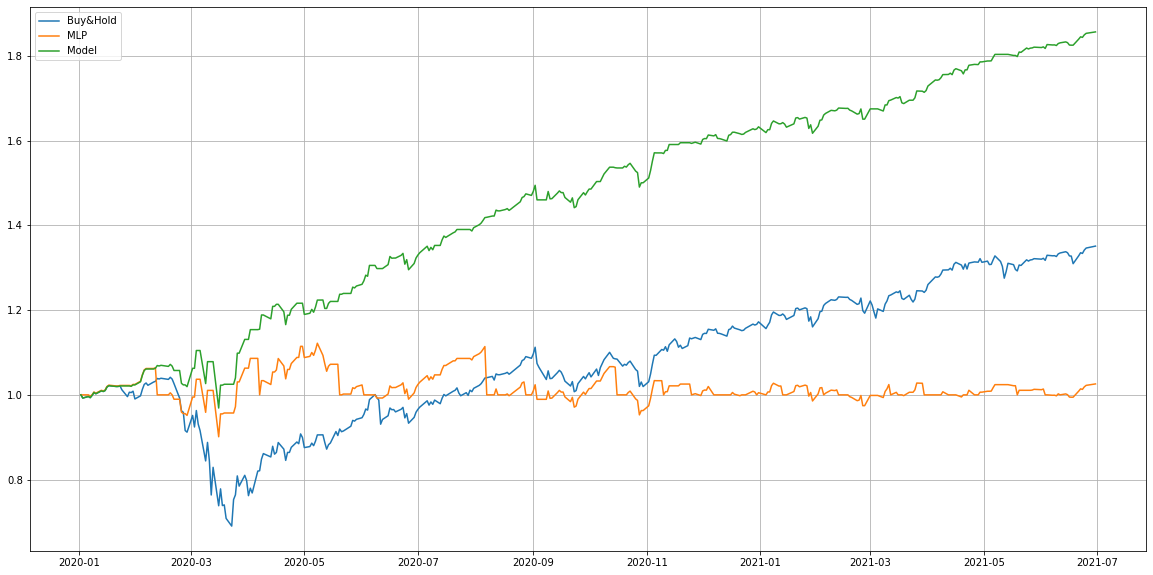

In [207]:
#x_test = normalize(X.loc[X.index > test_date],axis=0)
#y_test = y.loc[y.index > test_date]

Return = pd.DataFrame()
Return['Return'] = spy['Return'].loc[y_test.index]
Return['Return'][0] = 0
Return['Buy&Hold'] = (1 + Return['Return']).cumprod()
#result['Final'].loc[y_test.index][0] = 1

Return['model'] = 1
for idx,val in enumerate(y_test.index) :
    if idx==0:
        Return['model'].iloc[idx] = Return['Buy&Hold'].iloc[0]
    else:
        if result['Final'].loc[val] == 1 :
            Return['model'].loc[val] = Return['model'].iloc[idx-1] + Return['Return'].loc[val]
        if result['Final'].loc[val] == -1 :
            Return['model'].loc[val] = Return['model'].iloc[idx-1] 
        if result['Final'].loc[val] == 0 :
            for i in range(idx):
                if result['Final'].iloc[idx-i] == 1 :
                    Return['model'].loc[val] = Return['model'].iloc[idx-1] + Return['Return'].loc[val]
                    break
                if result['Final'].iloc[idx-i] == -1 :
                    Return['model'].loc[val] = Return['model'].iloc[idx-i]
                    break
                

Return['Bag'] = 1
for idx,val in enumerate(y_test.index) :
    if idx==0:
        Return['Bag'].iloc[idx] = 1
    else:
        if result['Bag'].loc[val] == 0 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] + Return['Return'].loc[val]
        if result['Bag'].loc[val] == 1 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] + Return['Return'].loc[val]
        if result['Bag'].loc[val] == -1 :
            Return['Bag'].loc[val] = Return['Bag'].iloc[idx-1] 
            
plt.figure(figsize=(20,10))
plt.plot(Return['Buy&Hold'],label='Buy&Hold')
plt.plot(Return['model'],label='MLP')
plt.plot(Return['Bag'],label='Model')

plt.legend()
plt.grid()
plt.show()

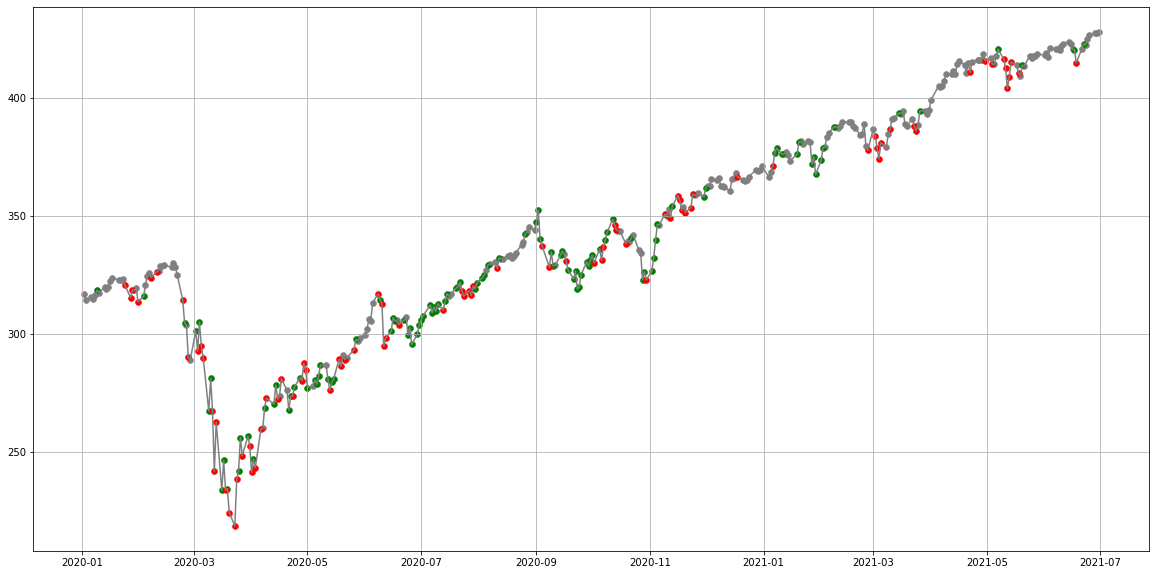

In [208]:
chart = pd.DataFrame()
chart['Price'] = spy['Adj Close'].loc[spy.index > test_date]
chart['Signal'] = result['Bag'].loc[result.index > test_date]

chart['Buy'] = chart['Price'].loc[chart['Signal']==1]
chart['Sell'] = chart['Price'].loc[chart['Signal']==-1]
chart['Hold'] = chart['Price'].loc[chart['Signal']==0]

plt.figure(figsize=(20,10))
plt.plot(chart['Price'],c='gray')
plt.scatter(chart.index,chart['Hold'],c='gray',linewidths=0.5)
plt.scatter(chart.index,chart['Buy'],c='green',linewidths=0.5)
plt.scatter(chart.index,chart['Sell'],c='red',linewidths=0.5)
plt.grid()
plt.show()

In [131]:
result[1300:1350]

,Real,MLP,RF,SVM,KNN,past Real,Final,Bag
Date,,,,,,,,
2020-03-24,1,0,-1,-1,-1,1.0,-1,-1
2020-03-25,1,0,1,-1,1,1.0,1,1
2020-03-26,-1,0,1,1,1,1.0,-1,-1
2020-03-27,1,0,1,-1,-1,-1.0,1,1
2020-03-30,-1,0,-1,0,-1,1.0,-1,-1
2020-03-31,-1,0,-1,-1,-1,-1.0,-1,-1
2020-04-01,1,0,-1,-1,-1,-1.0,-1,-1
2020-04-02,-1,0,1,1,-1,1.0,-1,-1
2020-04-03,1,0,-1,-1,-1,-1.0,-1,-1


In [108]:
result['Final'].loc['2021-01-04'] = 1

In [125]:
result['Final'].loc[y_test.index]

Date
2020-01-02    0
2020-01-03    0
2020-01-06    0
2020-01-07    0
2020-01-08    0
             ..
2021-06-24    0
2021-06-25    0
2021-06-28    0
2021-06-29    0
2021-06-30    0
Name: Final, Length: 377, dtype: int64

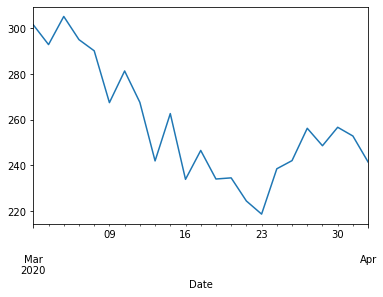

In [136]:
spy['Adj Close'].loc['2020-03-01':'2020-04-01'].plot()

In [198]:
result['Bag'].loc['2020-03-23':'2020-03-23'] = -1

In [148]:
result['Bag'].loc['2020-03-01':'2020-03-23']

Date
2020-03-02    1
2020-03-03    1
2020-03-04    1
2020-03-05   -1
2020-03-06   -1
2020-03-09   -1
2020-03-10   -1
2020-03-11   -1
2020-03-12   -1
2020-03-13   -1
2020-03-16   -1
2020-03-17   -1
2020-03-18   -1
2020-03-19   -1
2020-03-20   -1
2020-03-23    1
Name: Bag, dtype: int64

In [152]:
result.loc['2020-03-01':'2020-03-23']

,Real,MLP,RF,SVM,KNN,past Real,Final,Bag
Date,,,,,,,,
2020-03-02,-1,0,-1,1,0,1.0,-1,1
2020-03-03,1,0,-1,1,1,-1.0,-1,1
2020-03-04,-1,0,1,0,-1,1.0,1,1
2020-03-05,-1,0,1,0,-1,-1.0,1,-1
2020-03-06,-1,0,-1,1,-1,-1.0,-1,-1
2020-03-09,1,0,-1,1,-1,-1.0,-1,-1
2020-03-10,-1,0,1,1,-1,1.0,1,-1
2020-03-11,-1,0,1,1,-1,-1.0,1,-1
2020-03-12,1,0,1,1,1,-1.0,1,-1


In [184]:
id = 10
for i in range(id):
    print (i)

0
1
2
3
4
5
6
7
8
9


In [195]:
for idx,val in enumerate(y_test.index) :
    print (idx)
    print (val)
    break

0
2020-01-02 00:00:00
